In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BertTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from ComponentDataset import ComponentDataset
from BERTClassifier import BERTClassifier
from train_and_evaluate import train, evaluateModel

In [ ]:
def load_claim_data(data_file):
    df = pd.read_csv(data_file)
    df_majority = df[df.label == 0]
    df_minority = df[df.label == 1]

    print(df_minority.shape[0])
    print(df_majority.shape[0])

    minority_count = df_minority.shape[0]
    df_majority_downsampled = df_majority.sample(minority_count)
    df_resampled = pd.concat([df_majority_downsampled, df_minority])
    df_resampled = df_resampled.sample(frac=1).reset_index(drop=True)
    print(df_resampled.shape[0])
    sentences = df_resampled['sentence'].tolist()
    topics = df_resampled['topic'].tolist()
    labels = df_resampled['label'].tolist()
    return (sentences, topics), labels

In [ ]:
data_file = "../processed_dataset/claims.csv"
(sentences, topics), labels = load_claim_data(data_file)

2310
83303
4620


In [ ]:
bert_model_name = 'bert-large-cased'
num_classes = 2
max_length = 256
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [ ]:
train_sentences, val_sentences, train_topics, val_topics,train_labels, val_labels = train_test_split(sentences, topics, labels, test_size=0.2, random_state=42)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = ComponentDataset(train_sentences, train_topics, train_labels, tokenizer, max_length)
val_dataset = ComponentDataset(val_sentences, val_topics, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, roc, report = evaluateModel(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"roc: {roc:.4f}")
    print(report)

Epoch 1/4


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Validation Accuracy: 0.8593
roc: 0.8594
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       463
           1       0.84      0.89      0.86       461

    accuracy                           0.86       924
   macro avg       0.86      0.86      0.86       924
weighted avg       0.86      0.86      0.86       924

Epoch 2/4


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Validation Accuracy: 0.8723
roc: 0.8724
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       463
           1       0.84      0.93      0.88       461

    accuracy                           0.87       924
   macro avg       0.88      0.87      0.87       924
weighted avg       0.88      0.87      0.87       924

Epoch 3/4


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Validation Accuracy: 0.8831
roc: 0.8832
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       463
           1       0.85      0.94      0.89       461

    accuracy                           0.88       924
   macro avg       0.89      0.88      0.88       924
weighted avg       0.89      0.88      0.88       924

Epoch 4/4


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Validation Accuracy: 0.8907
roc: 0.8908
              precision    recall  f1-score   support

           0       0.93      0.84      0.89       463
           1       0.86      0.94      0.90       461

    accuracy                           0.89       924
   macro avg       0.89      0.89      0.89       924
weighted avg       0.89      0.89      0.89       924



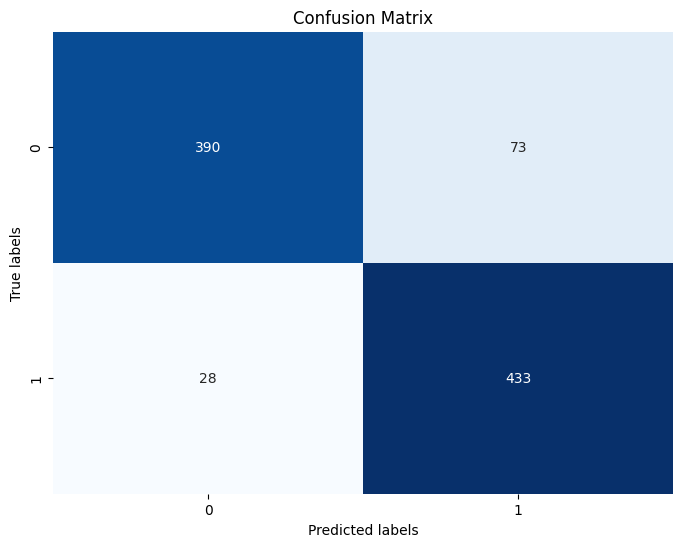

In [ ]:
def draw_confusion_matrix(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    cm = confusion_matrix(actual_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

draw_confusion_matrix(model, val_dataloader, device)

In [ ]:
model_path = '../models/claim.pth'
torch.save(model.state_dict(), model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>